/usr/lib/python3/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


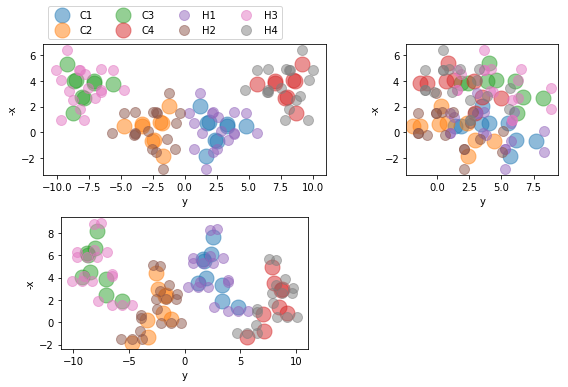

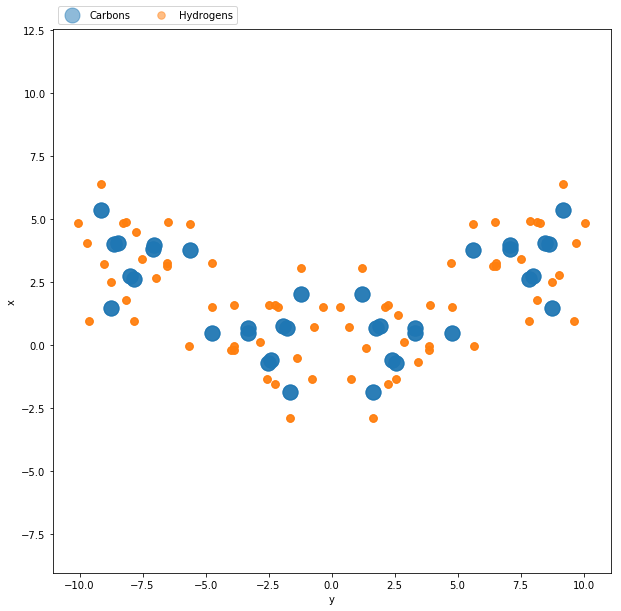

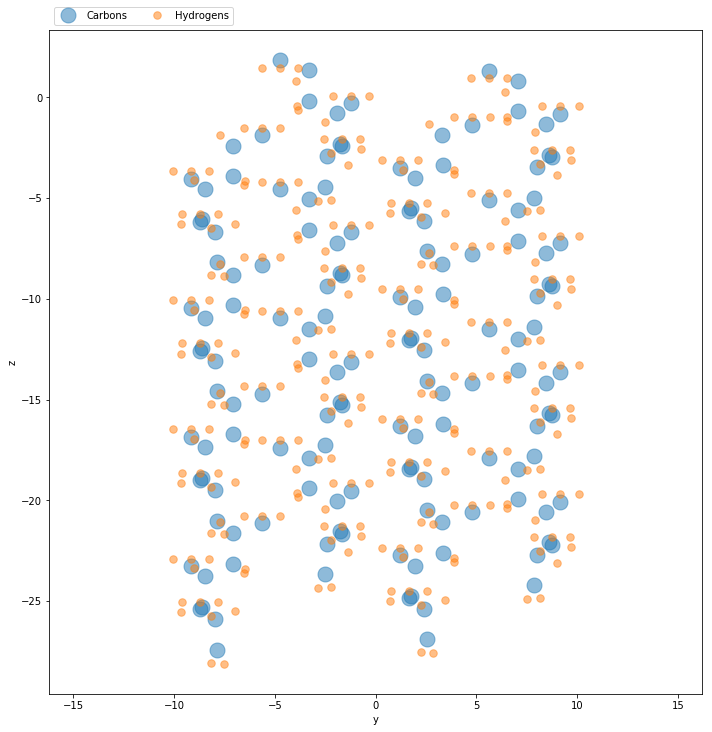

In [13]:
import numpy
import math
from matplotlib import pyplot


''' Atomic fractional coordiantes x/a, y/b, and z/c
from (1988 Macromolecules Immiczi and Iannelil) 
Comments indicate bonding. '''

C1 = numpy.array([[-0.0727, 0.2291, 0.2004],  #C3 0: 1
                  [-0.0765, 0.1592, 0.2788],  #C1 1: 0 2
                  [-0.1021, 0.1602, 0.5098],  #C2 2: 1 4
                  [-0.3087, 0.0589, 0.4941],  #C3 3: 4
                  [-0.1146, 0.0928, 0.6057],  #C1 4: 2 3 5
                  [-0.1044, 0.0854, 0.8428],  #C2 5: 4 7
                  [ 0.2775, 0.0797, 0.9260],  #C3 6: 7
                  [ 0.0872, 0.1156, 0.9730],  #C1 7: 5 6 8
                  [ 0.1026, 0.1221, 1.2109]]) #C2 8: 7

''' Angle between c vector and x-axis. '''
beta = 99.5 * numpy.pi / 180.0

''' Columns of unit_cell are the a, b, and c cell vectors. '''
unit_cell = numpy.array([[6.63,  0.00, 6.50*numpy.cos(beta)],
                         [0.00, 20.78, 0.0],
                         [0.00,  0.00, 6.50*numpy.sin(beta)]])


def apply_space_group(C1):
    ''' Edited symmetry operations to make figure match - not checked '''
    C2, C3, C4 = C1.copy(), C1.copy(), C1.copy()

    C2[:,0] =  C2[:,0]
    C2[:,1] = -C2[:,1]
    C2[:,2] =  C2[:,2] - 0.5

    C3[:,0] =  C3[:,0] - 0.5
    C3[:,1] =  C3[:,1] - 0.5
    C3[:,2] =  C3[:,2] 

    C4[:,0] =  C3[:,0] 
    C4[:,1] = -C3[:,1] 
    C4[:,2] =  C2[:,2]    
    
    return C1, C2, C3, C4


def sign(x):
        if x < 0:
            a = -1
        elif x > 0:
            a = 1
        return a
    
def outputfile(filename,a,b,c):
    filename = filename + '.txt'
    f = open(filename,'w+')

    f.write('LAMMPS data file via write_data, version 7 Aug 2019, timestep = 1000000\n\n')
    
    C, H = crystal(a,b,c)
    atoms = numpy.append(C,H, axis=0)
    f.write(str(len(atoms))+' atoms\n')

    atom_types = 4
    f.write(str(atom_types)+' atom types\n')

    CC_bonds = carbon_bonds(C)
    CH_bonds = hydrogen_bonds(C,H)
    bonds = numpy.append(CC_bonds,CH_bonds, axis=0)
    print(bonds)
    f.write(str(len(bonds))+' bonds\n')
    

    bond_types = 2
    f.write(str(bond_types)+'  bond types\n')
    
       
    theta = angles(bonds)
    f.write(str(len(theta))+'  angles\n')
    
    angle_types = 7   
    f.write(str(angle_types)+'  angle types\n')

    '''
    f.write('  dihedrals\n')

    f.write('  dihedral types\n')

    f.write('  impropers\n')

    f.write('  improper types\n\n')
    '''

    xlo = sign(numpy.amin(atoms[:,0])) + numpy.amin(atoms[:,0])
    xhi = sign(numpy.amax(atoms[:,0])) + numpy.amax(atoms[:,0])
    ylo = sign(numpy.amin(atoms[:,1])) + numpy.amin(atoms[:,1])
    yhi = sign(numpy.amax(atoms[:,1])) + numpy.amax(atoms[:,1])
    zlo = sign(numpy.amin(atoms[:,2])) + numpy.amin(atoms[:,2])
    zhi = sign(numpy.amax(atoms[:,2])) + numpy.amax(atoms[:,2])
    f.write(str(xlo)+' '+str(xhi)+'  xlo xhi\n'+str(ylo)+' '+str(yhi)+'  ylo yhi\n'+str(zlo)+
            ' '+str(zhi)+'  zlo zhi\n\n')

    Masses = numpy.array([12.0112, 12.0112, 12.0112,1.00797])
    f.write('Masses\n\n1 '+str(Masses[0])+'\n2 '+str(Masses[1])+'\n3 '+
            str(Masses[2])+'\n4 '+str(Masses[3])+'\n\n')

    '''
    f.write('Pair Coeffs # lj/class2/coul/long\n\n')

    f.write('Bond Coeffs class2\n\n')

    f.write('Angle Coeffs class2\n\n')

    f.write('BondBond Coeffs\n\n')

    f.write('BondAngle Coeffs\n\n')

    f.write('Dihedral Coeffs class2\n\n')

    f.write('AngleAngleTorsion Coeffs\n\n')

    f.write('EndBondTorsion Coeffs\n\n')

    f.write('MiddleBondTorsion Coeffs\n\n')

    f.write('BondBond13 Coeffs\n\n')

    f.write('AngleTorsion Coeffs\n\n')

    f.write('Improper Coeffs class2\n\n')

    f.write('AngleAngle Coeffs\n\n')
    '''
    
    f.write('Atoms #full\n\n')

    def __charge__(atom_id):
        if atom_id < len(C):
            if atom_id % 3 == 0:
                q = 0.530000
            else:
                q = -0.106000
        elif atom_id > len(C):
            q = 0.530000
        else:
            q = 0
        return q
    

    C_counter = 0
    H_counter = 0
    mol_tag = numpy.zeros(len(atoms))
    
    for i in range(len(atoms)):
        if i < len(C):   
            atom_type = 1
            if i >= C_counter*a*b*9 and i < (C_counter+1)*a*b*9:                
                mol_tag[i] = C_counter+1                
                f.write(str(int(i+1))+' '+str(int(mol_tag[i]))+' '+str(int(atom_type))+' '+str(__charge__(i))+
                        ' '+str(atoms[i,0])+' '+str(atoms[i,1])+' '+str(atoms[i,2])+'\n')                                
            else:
                C_counter = C_counter + 1
                mol_tag[i] = C_counter+1                
                f.write(str(int(i+1))+' '+str(int(mol_tag[i]))+' '+str(int(atom_type)) +' '+str(__charge__(i))+
                        ' '+str(atoms[i,0])+' '+str(atoms[i,1])+' '+str(atoms[i,2])+'\n')

        elif i >= len(C):
            atom_type = 2
            if i >= (H_counter*a*b*18+len(C)) and i < ((H_counter+1)*a*b*18+len(C)):
                mol_tag[i] = H_counter+1
                f.write(str(int(i+1))+' '+str(int(mol_tag[i]))+' '+str(int(atom_type))+' '+str(__charge__(i))+
                        ' '+str(atoms[i,0])+' '+str(atoms[i,1])+' '+str(atoms[i,2])+'\n')
            else:
                H_counter = H_counter+1
                mol_tag[i] = H_counter+1
                f.write(str(int(i+1))+' '+str(int(mol_tag[i]))+' '+str(int(atom_type))+' '+str(__charge__(i))+
                        ' '+str(atoms[i,0])+' '+str(atoms[i,1])+' '+str(atoms[i,2])+'\n')
    
    
    
    #f.write('\n\nVelocities\n\n')
    
    
    f.write('\n\nBonds\n\n')    
    counter = 0    
    for i in range(len(bonds)-1):
        if i < len(CC_bonds):
            bond_type = 1
            for j in range(4):
                if bonds[i,j] >= 0 and bonds[i,j] > i:                    
                    counter = counter + 1                   
                    f.write(str(int(counter))+' '+str(int(bond_type))+' '+str(int(i+1))+
                            ' '+str(int(bonds[i,j]+1))+'\n')                    
                

        elif i >= len(CC_bonds):
            bond_type = 2
            for j in range(4):
                if bonds[i,j] >=0:
                    counter = counter + 1                    
                    f.write(str(int(counter))+' '+str(int(bond_type))+' '+str(int(i+1+len(CC_bonds)))+
                            ' '+str(int(bonds[i,j]+1))+'\n')
         
    
    f.write('\n\nAngles\n\n')    
    for i in range(len(theta)):
        if i < len(C):
            angle_type = 1
            f.write(str(int(i+1))+' '+str(angle_type)+' '+str(theta[i][0]+1)+' '+
                    str(theta[i][1]+1)+' '+str(theta[i][2]+1)+'\n')
        else:
            angle_type = 2
            f.write(str(int(i+1))+' '+str(angle_type)+' '+str(theta[i][0]+1)+' '+
                    str(theta[i][1]+1)+' '+str(theta[i][2]+1)+'\n')

    
    #f.write('\n\nDihedrals\n\n')

    #f.write('\n\nImpropers\n\n')


def apply_hydrogens(C,i):
    ''' Construction of hydrogens from Theodorou (MD of aPP Melts) with 
    l_H=0.11 nm and theta_H=1.28 rad and c=+1 in C1 & C4 and c=-1 in C2 & C3'''   
    
    temp = numpy.zeros(3)
    H = numpy.zeros([18,3])
    l_H = 1.1
    theta_H = 1.28
    c = 1
    
    # Non-Methyl Hydrogens (Chiral and Gemini)
    # Chiral(Pendant) hydrogen
    # r_Hi = r_Ci+c*l_H*[((r_Ri)-(r_Ci-1))cross((r_Ri)-(r_Ci+1))/|((r_Ri)-(r_Ci-1))cross((r_Ri)-(r_Ci+1))|]
    
    def chiral_H_direction(Ci,Cj,Ck):      
        return unit_vector(numpy.cross(Ci-Cj, Ci-Ck))
    
    temp[0] = C[8,0]+1.07  # deducing along the unit cell c axis and transform it into orthonormal coordinates
    temp[1] = C[8,1]   
    temp[2] = C[8,2]-6.41
    H[0,:] = C[1,:] + c*l_H*chiral_H_direction(C[0,:],temp[:],C[2,:])
    H[3,:] = C[4,:] + c*l_H*chiral_H_direction(C[3,:],C[2,:],C[5,:])
    H[6,:] = C[7,:] + c*l_H*chiral_H_direction(C[6,:],C[5,:],C[8,:])
    
    
    # Gemini hydrogens 
    # b(i) = rc(i) - rc(i-1)/|rc(i)-rc(i-1)|
    b = [None]*6
        
    b[0] = unit_vector(C[2,:] - C[1,:])
    b[1] = unit_vector(C[4,:] - C[2,:])
    
    b[2] = unit_vector(C[5,:] - C[4,:])
    b[3] = unit_vector(C[7,:] - C[5,:])
    
    b[4] = unit_vector(C[8,:] - C[7,:])
    temp[0] = C[1,0]+1.07
    temp[1] = C[1,1]
    temp[2] = C[1,2]-6.41
    b[5] = unit_vector(temp[:] - C[8,:])


    # u(i) = (b(i) - b(i+1))/sqrt(2*(1-b(i).b(i+1))    
    u = [None]*3

    def bisector_vector(b1,b2):
        return (b1 - b2) / math.sqrt(2.0*(1.0 - numpy.dot(b1,b2)))
      
    # v(i) = (b(i) X b(i+1))/|b(i) X b(i+1)|
    v = [None]*3

    def plane_normal(b1,b2):
        return numpy.cross(b1,b2)/numpy.linalg.norm(numpy.cross(b1,b2))

    # rH(i) = rc(i) + lH*(sin(thetaH/2)*u(i) +- cos(thetaH/2)*v(i))
    def gemini_hydrogen(u,v,n):
        if n == 1:
            return (numpy.sin(theta_H/2)*u+numpy.cos(theta_H/2)*v)
        else:
            return (numpy.sin(theta_H/2)*u-numpy.cos(theta_H/2)*v)
    
    v[0] = plane_normal(b[0],b[1])
    u[0] = bisector_vector(b[0],b[1])
    H[1,:] = C[2,:]+l_H*gemini_hydrogen(u[0],v[0],1)
    H[2,:] = C[2,:]+l_H*gemini_hydrogen(u[0],v[0],2)

    v[1] = plane_normal(b[2],b[3])
    u[1] = bisector_vector(b[2],b[3])
    H[4,:] = C[5,:]+l_H*gemini_hydrogen(u[1],v[1],1)
    H[5,:] = C[5,:]+l_H*gemini_hydrogen(u[1],v[1],2)

    v[2] = plane_normal(b[4],b[5])
    u[2] = bisector_vector(b[4],b[5])
    H[7,:] = C[8,:]+l_H*gemini_hydrogen(u[2],v[2],1)
    H[8,:] = C[8,:]+l_H*gemini_hydrogen(u[2],v[2],2)  
    

    # Methyl Group Hydrogens 
    for i in range(0,9,3):
        H[9+i,0] = C[i,0] + sign(C[1+i,0])*1.037
        H[9+i,1] = C[i,1] 
        H[9+i,2] = C[i,2] - sign(C[1+i,2])*0.37
        H[10+i,0] = C[i,0] - sign(C[1+i,0])*0.5185        
        H[10+i,1] = C[i,1] + sign(C[1+i,1])*0.898
        H[10+i,2] = C[i,2] - sign(C[1+i,2])*0.37
        H[11+i,0] = C[i,0] - sign(C[1+i,0])*0.5185
        H[11+i,1] = C[i,1] - sign(C[1+i,1])*0.898       
        H[11+i,2] = C[i,2] - sign(C[1+i,2])*0.37
        
    return H
    


def plot_unit_cell(CC):
    
    C = numpy.vstack([numpy.dot(C, unit_cell) for C in apply_space_group(CC)])    
    H = numpy.zeros([72,3])
    
    for i in range(4):
        H[18*i:18*(i+1),:] = apply_hydrogens(C[9*i:9*(i+1),:],i) 
    
    lx, ly = unit_cell[0,0], unit_cell[1,1]
    
    figure = pyplot.figure(figsize=(9,5))
    aC = pyplot.subplot(221)
    aH = pyplot.subplot(221)
    
    aC.plot(C[:9,1],    -C[:9,0],    '.', ms=30, alpha=0.5, label='C1')
    aC.plot(C[9:18,1],  -C[9:18,0],  '.', ms=30, alpha=0.5, label='C2')
    aC.plot(C[18:27,1], -C[18:27,0], '.', ms=30, alpha=0.5, label='C3')
    aC.plot(C[27:36,1], -C[27:36,0], '.', ms=30, alpha=0.5, label='C4')
    aC.set_xlabel('y')
    aC.set_ylabel('-x')
    aC.set_aspect('equal')
    
    aH.plot(H[:18,1],    -H[:18,0],    '.', ms=20, alpha=0.5, label='H1')
    aH.plot(H[18:36,1],  -H[18:36,0],  '.', ms=20, alpha=0.5, label='H2')
    aH.plot(H[36:54,1], -H[36:54,0], '.', ms=20, alpha=0.5, label='H3')
    aH.plot(H[54:72,1], -H[54:72,0], '.', ms=20, alpha=0.5, label='H4')
    aH.set_xlabel('y')
    aH.set_ylabel('-x')
    aH.set_aspect('equal')
    
    pyplot.legend(ncol=4, bbox_to_anchor=(0,1), loc='lower left')
    aC = pyplot.subplot(222)
    aH = pyplot.subplot(222)
    
    aC.plot(C[:9,2],    -C[:9,0],    '.', ms=30, alpha=0.5, label='C1')
    aC.plot(C[9:18,2],  -C[9:18,0],  '.', ms=30, alpha=0.5, label='C2')
    aC.plot(C[18:27,2], -C[18:27,0], '.', ms=30, alpha=0.5, label='C3')
    aC.plot(C[27:36,2], -C[27:36,0], '.', ms=30, alpha=0.5, label='C4')
    aC.set_xlabel('z')
    aC.set_ylabel('-x')
    aC.set_aspect('equal')
    
    aH.plot(H[:18,2],    -H[:18,0],    '.', ms=20, alpha=0.5, label='H1')
    aH.plot(H[18:36,2],  -H[18:36,0],  '.', ms=20, alpha=0.5, label='H2')
    aH.plot(H[36:54,2], -H[36:54,0], '.', ms=20, alpha=0.5, label='H3')
    aH.plot(H[54:72,2], -H[54:72,0], '.', ms=20, alpha=0.5, label='H4')
    aH.set_xlabel('y')
    aH.set_ylabel('-x')
    aH.set_aspect('equal')

    aC = pyplot.subplot(223)
    aH = pyplot.subplot(223)

    aC.plot(C[:9,1],    C[:9,2],    '.', ms=30, alpha=0.5, label='C1')
    aC.plot(C[9:18,1],  C[9:18,2],  '.', ms=30, alpha=0.5, label='C2')
    aC.plot(C[18:27,1], C[18:27,2], '.', ms=30, alpha=0.5, label='C3')
    aC.plot(C[27:36,1], C[27:36,2], '.', ms=30, alpha=0.5, label='C4')
    aC.set_xlabel('y')
    aC.set_ylabel('z')
    aC.set_aspect('equal')
    
    aH.plot(H[:18,1],    H[:18,2],    '.', ms=20, alpha=0.5, label='H1')
    aH.plot(H[18:36,1],  H[18:36,2],  '.', ms=20, alpha=0.5, label='H2')
    aH.plot(H[36:54,1], H[36:54,2], '.', ms=20, alpha=0.5, label='H3')
    aH.plot(H[54:72,1], H[54:72,2], '.', ms=20, alpha=0.5, label='H4')
    aH.set_xlabel('y')
    aH.set_ylabel('-x')
    aH.set_aspect('equal')
    
    pyplot.tight_layout()
    
    return CC    


def unit_vector(v):
    return v / numpy.linalg.norm(v)

        
def crystal(a,b,c):
    ''' Creating the initial crystalline system - a & b & c are the dimensions of the system '''   
           
    C = numpy.vstack([C for C in apply_space_group(C1)])    
    Carbons = numpy.zeros([a*b*c*36,3])    
    Hydrogens = numpy.zeros([a*b*c*72,3])
                
    for i in range(a):
        Carbons[(36*i):(36*(i+1)),0] = C[:,0] + float(i)
        Carbons[(36*i):(36*(i+1)),1] = C[:,1]
        Carbons[(36*i):(36*(i+1)),2] = C[:,2]   
    
    for j in range(1,b):
        Carbons[36*(a*j):36*(a*(j+1)),0] = Carbons[0:36*a,0]
        Carbons[36*(a*j):36*(a*(j+1)),1] = Carbons[0:36*a,1] + float(j)         
        Carbons[36*(a*j):36*(a*(j+1)),2] = Carbons[0:36*a,2] 
        
    for k in range(1,c):
        Carbons[36*(a*b*k):36*(a*b*(k+1)),0] = Carbons[0:36*a*b,0]
        Carbons[36*(a*b*k):36*(a*b*(k+1)),1] = Carbons[0:36*a*b,1]          
        Carbons[36*(a*b*k):36*(a*b*(k+1)),2] = Carbons[0:36*a*b,2] + float(k)                    
    
    Carbons = numpy.dot(Carbons, unit_cell)   
    
    # number of chains = a*b*c*4
    for i in range(a*b*c*4):        
        Hydrogens[18*i:18*(i+1),:] = apply_hydrogens(Carbons[9*i:9*(i+1),:],i)            
        
    return Carbons, Hydrogens


def plot_crystal(C, H):
    
    fig1 = pyplot.figure(figsize = (10,10))      
    aC1 = pyplot.plot(C[:,1], -C[:,0],'.', ms=30, alpha=0.5, label='Carbons')
    aH1 = pyplot.plot(H[:,1], -H[:,0],'.', ms=15, alpha=0.5, label='Hydrogens')
    pyplot.xlabel('y')
    pyplot.ylabel('x')
    pyplot.axis('equal')
    pyplot.legend(ncol=4, bbox_to_anchor=(0,1), loc='lower left')
    
    fig2 = pyplot.figure(figsize = (10,10))    
    aC2 = pyplot.plot(C[:,1], -C[:,2],'.', ms=30, alpha=0.5, label='Carbons')
    aH2 = pyplot.plot(H[:,1], -H[:,2],'.', ms=15, alpha=0.5, label='Hydrogens')
    pyplot.xlabel('y')
    pyplot.ylabel('z')   
    pyplot.axis('equal')
    pyplot.legend(ncol=4, bbox_to_anchor=(0,1), loc='lower left')
    pyplot.tight_layout()

CC = plot_unit_cell(C1)
a = 1
b = 1 
c = 4

C, H = crystal(a,b,c)
plot_crystal(C, H)


In [14]:
# Determine which carbn atoms are bonded to each other.
def carbon_bonds(C):
    C_bonds = numpy.empty([len(C),4])
    C_bonds.fill(-1)
    for i in range(len((C))):
        s = '{}:'.format(i)
        counter = 0
        for j in range(len(C)):
            d = numpy.linalg.norm(C[i,:]-C[j,:])
            if i != j and d < 1.6:
                s += ' {} '.format(j)
                C_bonds[i,counter] = j
                counter = counter + 1    
    return C_bonds

CC_bonds = carbon_bonds(C)


# Determine which hydrogen is connected to what carbon
def hydrogen_bonds(C,H):
    H_bonds = numpy.empty([len(C),4])
    H_bonds.fill(-1)
    for i in range(len(C)):
        h1 = '{}:'.format(i)
        counter = 0
        for j in range(len(H)):
            dist = numpy.linalg.norm(C[i,:]-H[j,:])
            if abs(dist - 1.1) < 0.1:
                h1 += '{} '.format(j)
                H_bonds[i,counter] = j
                counter = counter + 1    
    return H_bonds

CH_bonds = hydrogen_bonds(C,H)



In [15]:
# Dteremine the angle between the Carbons
def angles(bonds):       
    total_angles = []
    for i,b in enumerate(bonds):
        atoms = [int(a) for a in b if a != -1]
        if len(atoms) < 2: 
            continue
        if len(atoms) == 2:
            total_angles.append(numpy.array([atoms[0], i, atoms[1]]))
        else:
            total_angles.append(numpy.array([atoms[0], i, atoms[1]]))
            total_angles.append(numpy.array([atoms[0], i, atoms[2]]))
            total_angles.append(numpy.array([atoms[1], i, atoms[2]]))
    
    return total_angles
        
outputfile('Alpha_iPP_'+str(a)+'a'+str(b)+'b'+str(c)+'c',a,b,c)
        

[[   1.   -1.   -1.   -1.]
 [   0.    2.   -1.   -1.]
 [   1.    4.   -1.   -1.]
 ..., 
 [ 285.  286.  287.   -1.]
 [ 276.  285.   -1.   -1.]
 [ 277.  278.   -1.   -1.]]


In [16]:
'''
a = {'c1': 1, 'c2':2, 'c3':3, 'h': 4}



atom_types = [1, 2, 3, 4]

for idx in atoms:
    pass

# bond
#bond = [[1,2], [2,3], [3,4]]

# angle 
#angle = [[1,2,3], [2,3,4]]


natoms = 1000
atom_id_type = []
for atom in range(natoms):
    t = 2
    if atom % 2 == 0: t = 1
    atom_id_type.append([t, atom])


# branch carbon
bonds = []
branch_c = []
for atom in atom_id_type:
    if atom[0] == 1:
        branch_c.append([3, len(branch_c) + len(atom_id_type)])
        '''

"\na = {'c1': 1, 'c2':2, 'c3':3, 'h': 4}\n\n\n\natom_types = [1, 2, 3, 4]\n\nfor idx in atoms:\n    pass\n\n# bond\n#bond = [[1,2], [2,3], [3,4]]\n\n# angle \n#angle = [[1,2,3], [2,3,4]]\n\n\nnatoms = 1000\natom_id_type = []\nfor atom in range(natoms):\n    t = 2\n    if atom % 2 == 0: t = 1\n    atom_id_type.append([t, atom])\n\n\n# branch carbon\nbonds = []\nbranch_c = []\nfor atom in atom_id_type:\n    if atom[0] == 1:\n        branch_c.append([3, len(branch_c) + len(atom_id_type)])\n        "